In [9]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load Image Dataset

In [2]:
# Define the path to the dataset
base_path = r"C:\Users\rakat.murshed\Documents\Datasets\x_ray\chest_xray\train"

# Define the subfolders
subfolders = ['NORMAL', 'PNEUMONIA']

# Collect all image paths and labels
image_paths = []
labels = []

for subfolder in subfolders:
    folder_path = os.path.join(base_path, subfolder)
    if os.path.exists(folder_path):
        for file in os.listdir(folder_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(folder_path, file))
                labels.append(subfolder)

print(f"Total number of images: {len(image_paths)}")

Total number of images: 5216


# Image Processing

In [3]:
# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Function to preprocess images
def preprocess_image(image_path, target_size=image_size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize the image
    return img

In [4]:
# Preprocess all images
X = np.array([preprocess_image(img_path) for img_path in image_paths])
y = np.array([1 if label == 'PNEUMONIA' else 0 for label in labels])

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

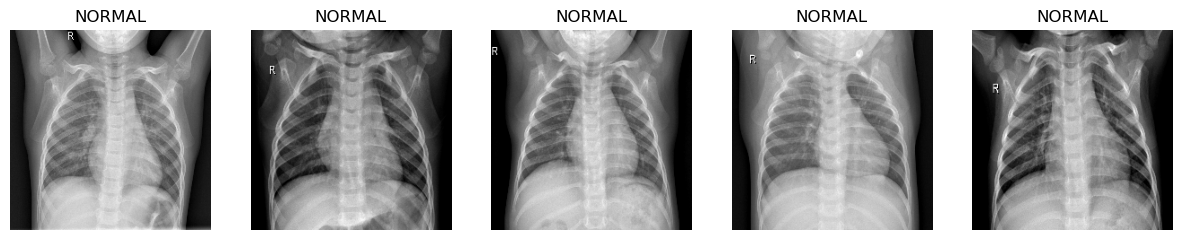

In [6]:
# Show 5 preprocessed images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.title('PNEUMONIA' if y[i] == 1 else 'NORMAL')
    plt.axis('off')
plt.show()

# Build CNN Model

In [7]:
# Define the custom CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(*image_size, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [10]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduced splits
epochs = 10  # Reduced epochs

train_mse = []
train_r2 = []
val_mse = []
val_r2 = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = create_model()
    
    history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_mse.append(mean_squared_error(y_train, y_train_pred))
    train_r2.append(r2_score(y_train, y_train_pred))
    val_mse.append(mean_squared_error(y_val, y_val_pred))
    val_r2.append(r2_score(y_val, y_val_pred))
    
    print(f"Train MSE: {train_mse[-1]}, Train R2: {train_r2[-1]}")
    print(f"Val MSE: {val_mse[-1]}, Val R2: {val_r2[-1]}")

C:\Users\rakat.murshed\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\rakat.murshed\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6995 - loss: 1.0442 - val_accuracy: 0.7056 - val_loss: 0.5814
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.7874 - loss: 0.4225 - val_accuracy: 0.6567 - val_loss: 0.6287
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8390 - loss: 0.3421 - val_accuracy: 0.8585 - val_loss: 0.3130
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8565 - loss: 0.3159 - val_accuracy: 0.9235 - val_loss: 0.2258
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.8673 - loss: 0.3061 - val_accuracy: 0.9241 - val_loss: 0.2592
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8785 - loss: 0.2841 - val_accuracy: 0.8677 - val_loss: 0.3108
109/109 ━━━━━━━━━━━━━━━━━━━━ 42s 379ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step
Train MSE: 0.06658487934582111, Train R2: 0.6464346854890501
Val MSE: 0.0654772402644343, Val R2: 0.6662085484497751


C:\Users\rakat.murshed\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\rakat.murshed\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7378 - loss: 0.5987 - val_accuracy: 0.7286 - val_loss: 0.4886
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.7960 - loss: 0.4275 - val_accuracy: 0.8424 - val_loss: 0.3649
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8357 - loss: 0.3619 - val_accuracy: 0.8597 - val_loss: 0.3175
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.8306 - loss: 0.3560 - val_accuracy: 0.7470 - val_loss: 0.4336
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8640 - loss: 0.3171 - val_accuracy: 0.8516 - val_loss: 0.3167
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.8674 - loss: 0.3151 - val_accuracy: 0.8769 - val_loss: 0.3063
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8678 - loss: 0.3077 - val_accuracy: 0.8953 - val_loss: 0.2471
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.8768 - loss: 0.2779 - val_accuracy: 0.821

C:\Users\rakat.murshed\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\rakat.murshed\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.7076 - loss: 0.6355 - val_accuracy: 0.7365 - val_loss: 0.5404
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8153 - loss: 0.3768 - val_accuracy: 0.8562 - val_loss: 0.3263
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.8450 - loss: 0.3330 - val_accuracy: 0.8895 - val_loss: 0.2531
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8581 - loss: 0.3086 - val_accuracy: 0.9062 - val_loss: 0.2458
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.8722 - loss: 0.2849 - val_accuracy: 0.8947 - val_loss: 0.2377
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8812 - loss: 0.2574 - val_accuracy: 0.9160 - val_loss: 0.2028
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8772 - loss: 0.2716 - val_accuracy: 0.9033 - val_loss: 0.2389
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.8878 - loss: 0.2689 - val_accuracy: 0.917

# Error Analysis

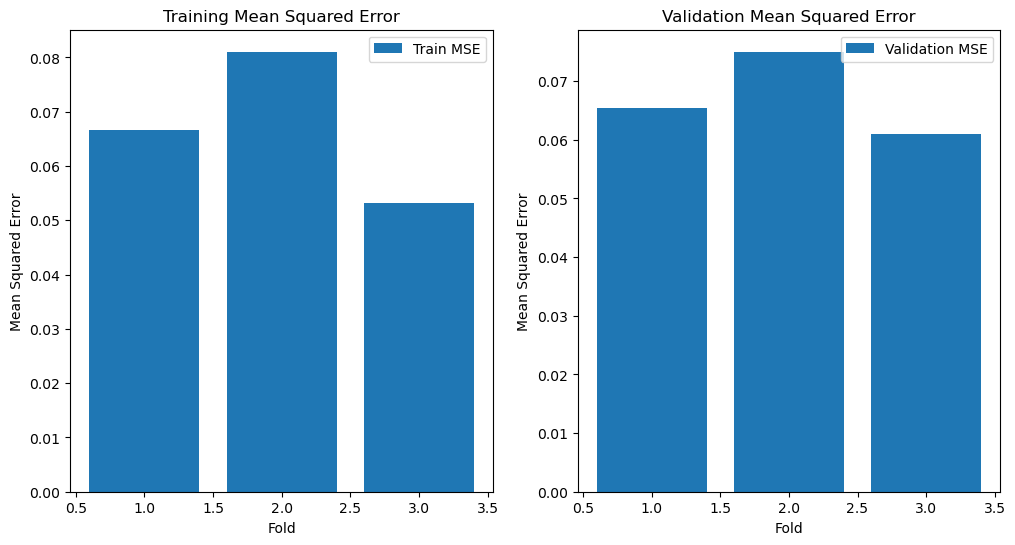

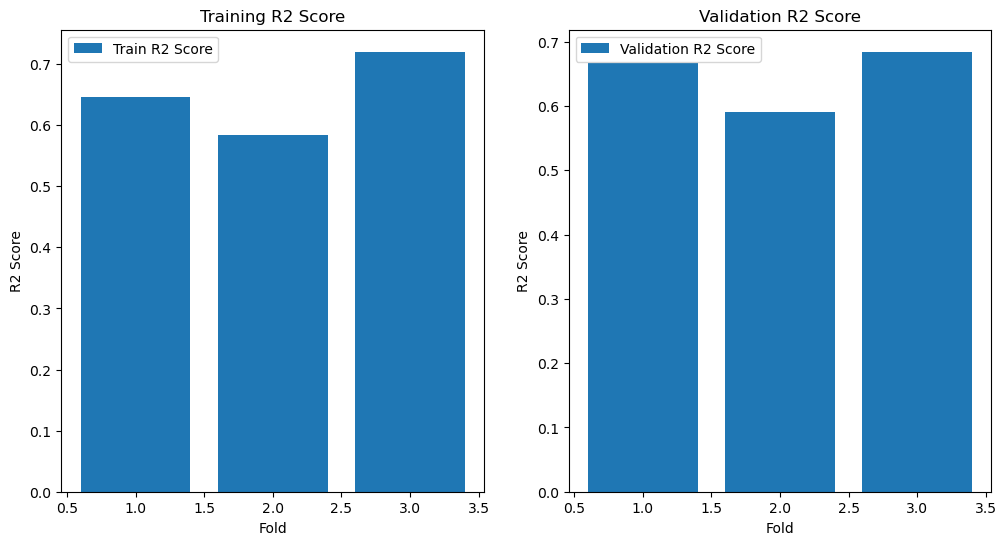

In [13]:
fold_range = range(1, len(train_mse) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(fold_range, train_mse, label='Train MSE')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Training Mean Squared Error')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(fold_range, val_mse, label='Validation MSE')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Validation Mean Squared Error')
plt.legend()

plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(fold_range, train_r2, label='Train R2 Score')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.title('Training R2 Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(fold_range, val_r2, label='Validation R2 Score')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.title('Validation R2 Score')
plt.legend()

plt.show()